0.007843137254901933 1.0 0.14969852436576353


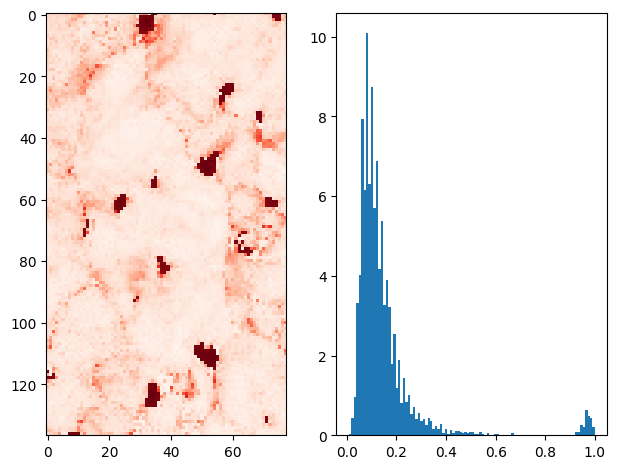

In [73]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy
import pandas as pd
import dionysus as d
import networkx
from tqdm.auto import tqdm
from scipy import stats

# im_test = np.array(Image.open("../figures/GND15pct_rotated.jpg").convert("RGB"))
# im_gray = 1-np.array(Image.open("../figures/GND0pct_rotated.jpg").convert("L").resize((100,100))).astype(int)/255
im_gray = 1-np.array(Image.open("../figures/Small_10pct.png").convert("L")).astype(int)/255
# im_norm = im_test.astype(int)/255
print(np.min(im_gray), np.max(im_gray), np.mean(im_gray.flatten()))
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_gray, cmap="Reds")
ax[1].hist(im_gray.flatten(), bins=100, density=True)
fig.tight_layout()
plt.show()

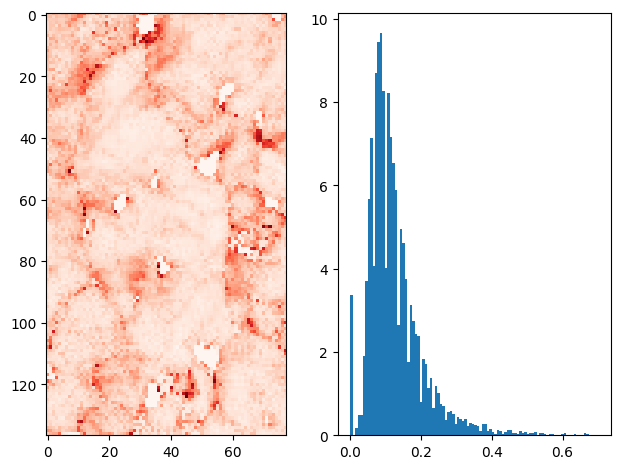

In [74]:
im_red = copy.deepcopy(im_gray)
im_red[im_red > 0.8] = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_red, cmap="Reds")
ax[1].hist(im_red.flatten(), bins=100, density=True)
fig.tight_layout()
plt.show()

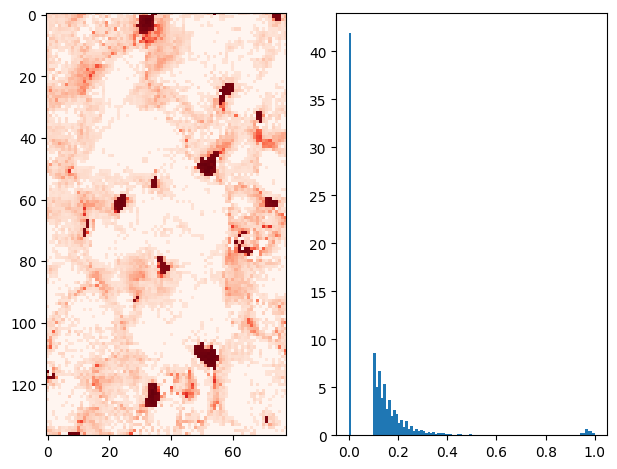

In [75]:
im_grain = copy.deepcopy(im_gray)
im_grain[im_grain < 0.10] = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_grain, cmap="Reds")
ax[1].hist(im_grain.flatten(), bins=100, density=True)
fig.tight_layout()
plt.show()

Amount of points: 3053


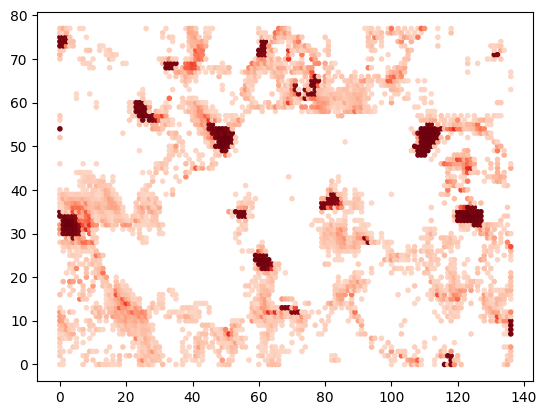

In [76]:
X = np.vstack(np.where(im_gray>np.mean(im_gray))).T
y = np.array([im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])])
print("Amount of points:", len(y))
plt.scatter(X[:,0], X[:,1], marker=".", c=y, cmap="Reds", vmin=0, vmax=1)

In [77]:
from sklearn.datasets import make_circles
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from tdamapper.learn import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperPlot

# load a labelled dataset
# X, labels = make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=42)
# y = X[:,1]

cover = CubicalCover(n_intervals=25, overlap_frac=0.3, algorithm="standard")
clust = DBSCAN(eps=5)
graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

# color according to labels
fig, node_col = MapperPlot(graph, dim=3, seed=42, iterations=60, layout_engine="networkx").plot_plotly(colors=y, cmap="Reds")
fig.show(config={'scrollZoom': True})


Node_col:
 {435: 0.1703081232492997, 434: 0.17797888386123678, 433: 0.20873440285204994, 432: 0.24460784313725492, 431: 0.2313725490196078, 430: 0.2591800356506239, 417: 0.206951871657754, 429: 0.6244343891402715, 428: 0.8823529411764708, 427: 0.47857142857142865, 426: 0.24040920716112535, 420: 0.5164404223227753, 419: 0.47750865051903113, 418: 0.24741532976827096, 416: 0.1906485671191553, 398: 0.16764705882352943, 413: 0.17843137254901956, 397: 0.20620915032679735, 410: 0.24901960784313726, 409: 0.22189542483660132, 408: 0.24418300653594777, 407: 0.4395424836601307, 406: 0.49921568627450974, 405: 0.3371323529411765, 404: 0.22366463826910077, 402: 0.17005347593582887, 411: 0.2334841628959276, 412: 0.2159663865546218, 403: 0.18879551820728294, 401: 0.17009803921568628, 399: 0.19058823529411764, 394: 0.1728291316526611, 393: 0.17450980392156862, 392: 0.23159041394335508, 391: 0.23238925199709512, 379: 0.23547237076648841, 390: 0.2427637721755369, 389: 0.24913494809688583, 388: 0.24836601

KeyError: 79

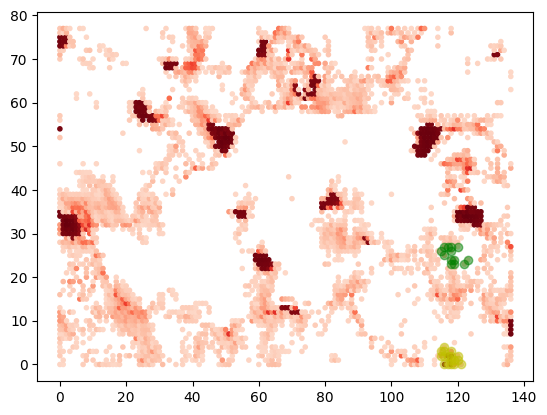

In [51]:
plt.scatter(X[:,0], X[:,1], marker=".", c=y, cmap="Reds", vmin=0, vmax=1)
plt.scatter(X[graph.nodes[51]["ids"],0], X[graph.nodes[51]["ids"],1], marker="o", c="y", alpha=0.5)
plt.scatter(X[graph.nodes[47]["ids"],0], X[graph.nodes[47]["ids"],1], marker="o", c="g", alpha=0.5)
plt.scatter(X[graph.nodes[79]["ids"],0], X[graph.nodes[79]["ids"],1], marker="o", c="b", alpha=0.5)
plt.scatter(X[graph.nodes[12]["ids"],0], X[graph.nodes[12]["ids"],1], marker="o", c="black", alpha=0.5)


Amoung of simplices: 2202, 
0D: 366 		 1D: 938 
2D: 728 		 3D: 170.


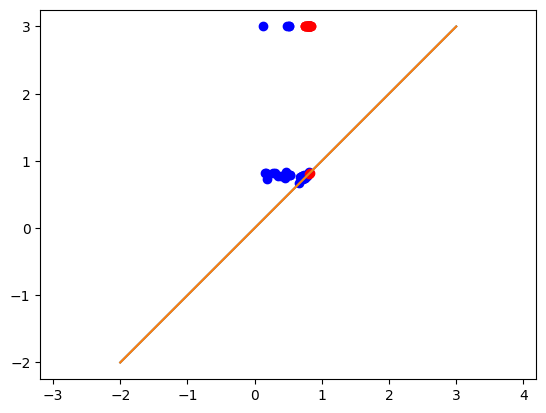

In [78]:
fig, ax = plt.subplots(1,1)
simplices = []
for c in networkx.enumerate_all_cliques(graph):
    # if len(c) <= 2:
    simplices.append((c, np.max([1-node_col[i] for i in c])))
    # else:
    #     simplices.append((c, np.sum([1-y[i] for i in c])))

print(f"Amoung of simplices: {len(simplices)}, \n"
        f"0D: {len([c for c in simplices if len(c[0]) == 1])} \t\t 1D: {len([c for c in simplices if len(c[0]) == 2])} \n"
        f"2D: {len([c for c in simplices if len(c[0]) == 3])} \t\t 3D: {len([c for c in simplices if len(c[0]) == 4])}.")
f = d.Filtration()
for vertices, time in simplices:
    f.append(d.Simplex(vertices, time))
f.sort()
p = d.cohomology_persistence(f, 47, True)
dgms = d.init_diagrams(p, f)
d.plot.plot_all_diagrams(dgms, ax=ax)

In [81]:
cocycles = []
birth_deaths = []
for point in dgms[1]:
    if point.death-point.birth <2:
        birth_deaths.append((point.birth, point.death))
        cocycles.append(p.cocycle(point.data))
len(cocycles)

2

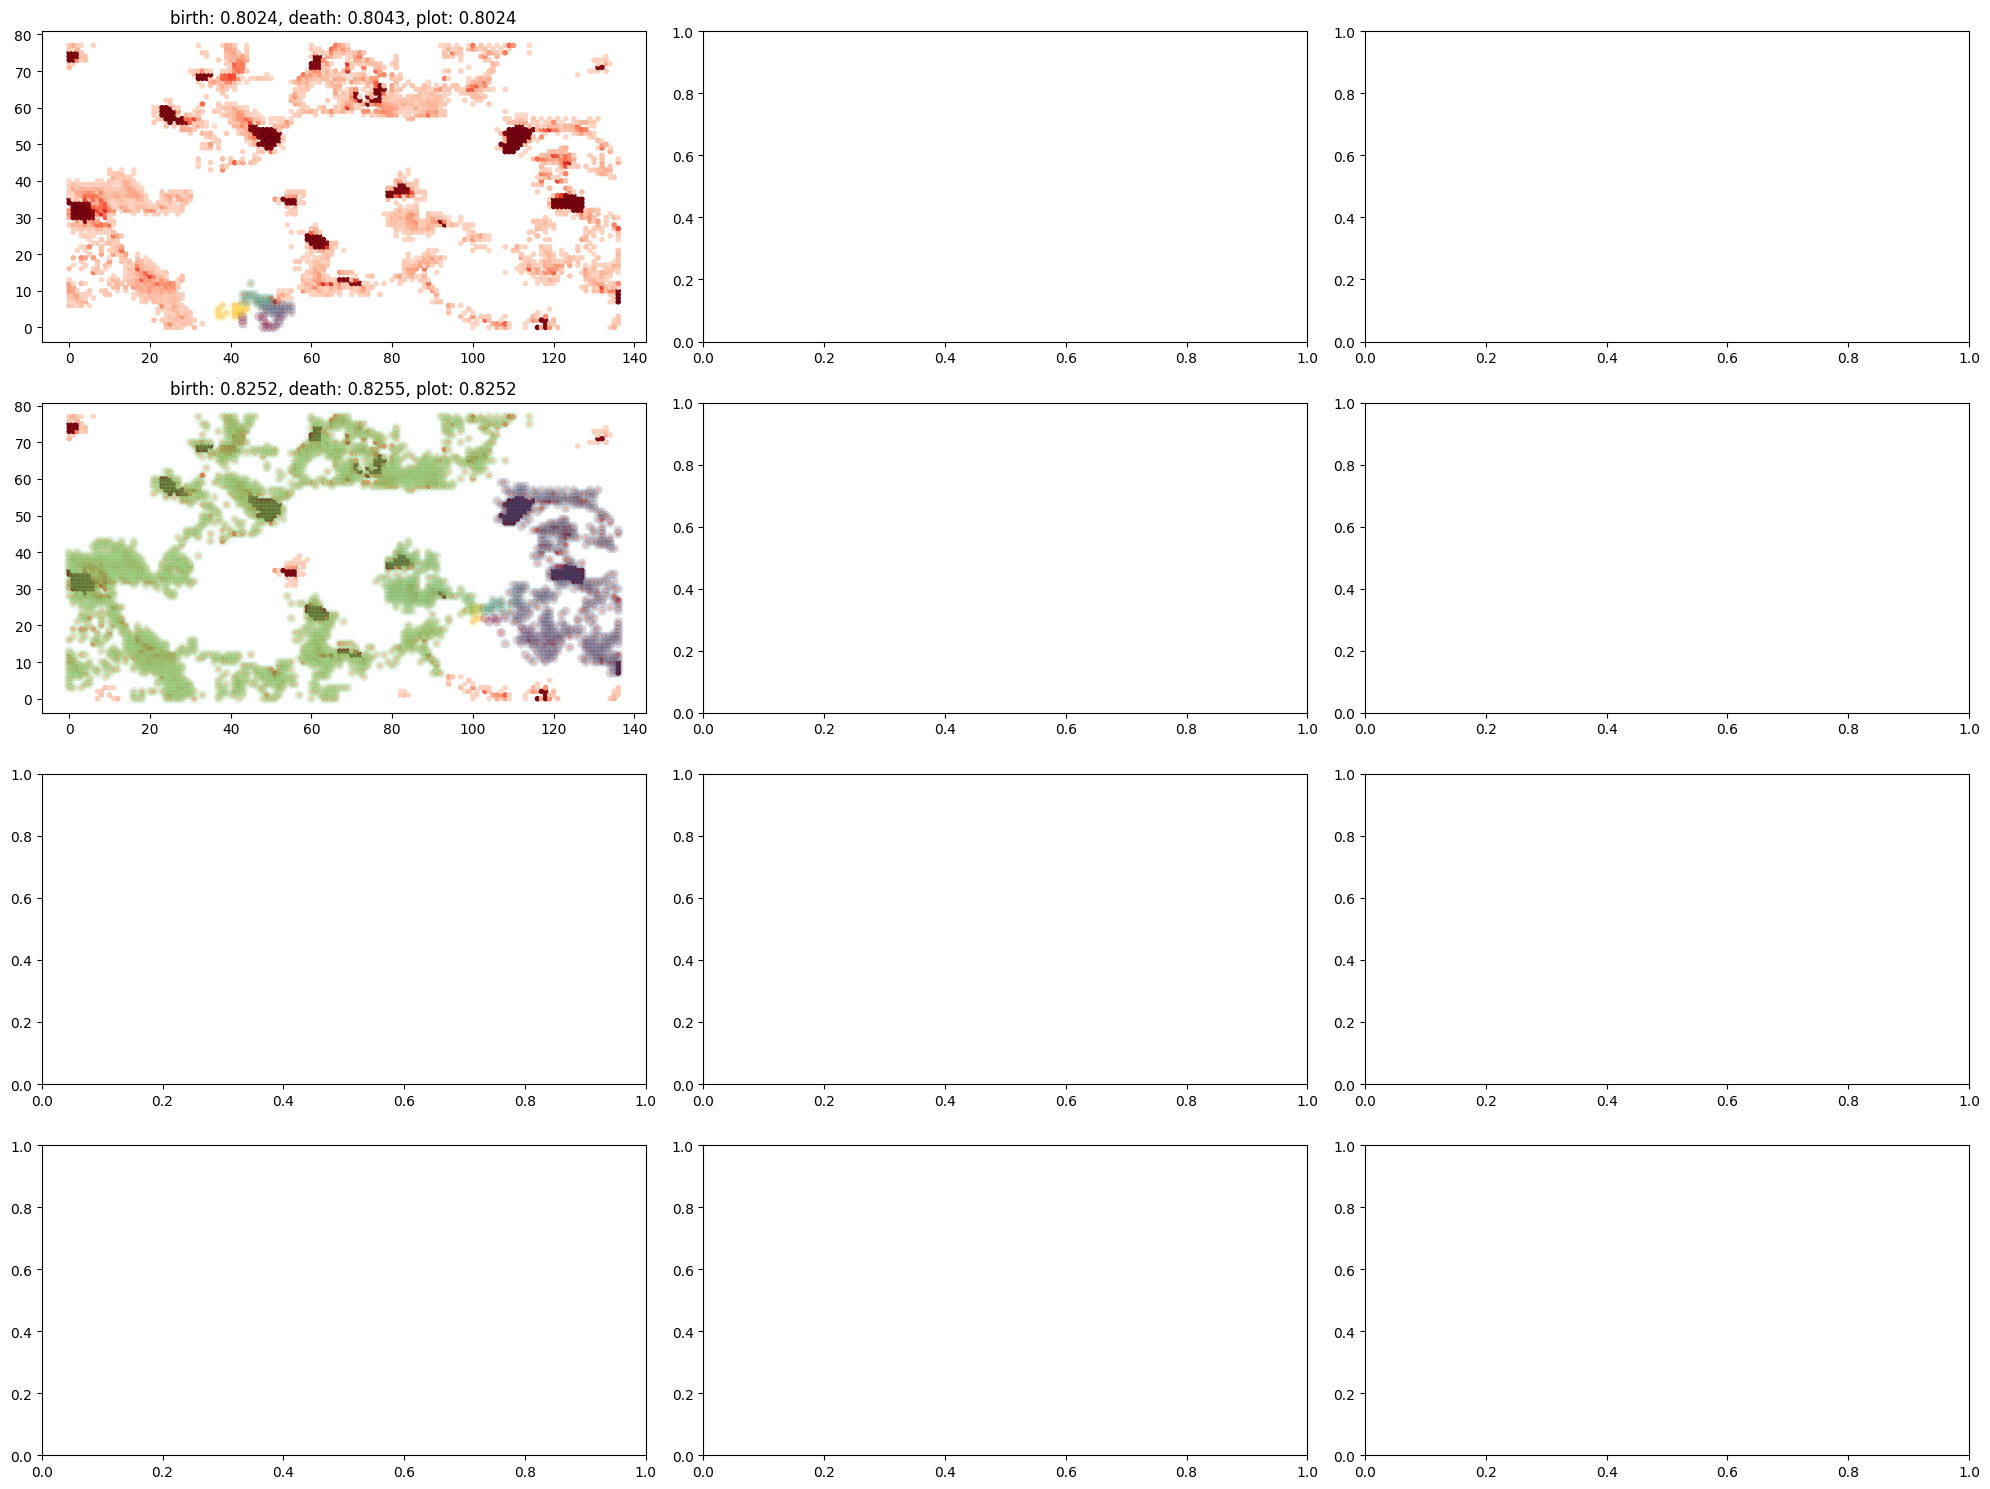

In [82]:
point_i = 1

fig, axs = plt.subplots(4, 3)
fig.set_size_inches(20,15)
vertex_values_list = []
used_nodes_list = []
for point_i in range(min(len(cocycles), 12)):
    point_birth = birth_deaths[point_i][0]
    point_death = birth_deaths[point_i][1]
    plot_time = point_birth+(point_death-point_birth)/100
    f_restricted = d.Filtration([s for s in f if s.data < plot_time])
    
    used_vertex_ids = []
    used_nodes_ids = []
    for s in f_restricted:
        if s.dimension() == 0:
            used_vertex_ids += graph.nodes[s[0]]["ids"]
            used_nodes_ids.append(s[0])
    used_vertex_ids = np.array(list(set(used_vertex_ids)))
    used_nodes_list.append(used_nodes_ids)
    X_restricted = X[used_vertex_ids, :]

    vertex_values = d.smooth(f_restricted, cocycles[point_i], 47)
    vertex_values_list.append(vertex_values)
    point_values = np.zeros(X.shape[0])
    point_values_i = np.zeros(X.shape[0])
    for s in f_restricted:
        if s.dimension() == 0:
            node = s[0]
        else:
            continue
        for point_id in graph.nodes[node]["ids"]:
            try:
                point_values[point_id] = vertex_values[int(node)]
            except:
                print(node, point_id)
                raise IndexError
            point_values_i[point_id] += 1
    point_values =np.array(point_values)[used_vertex_ids]
    # point_values = np.array([point_values[i]/max(point_values_i[i], 1) for i in range(len(point_values))])
    axs[point_i%4, point_i//4].scatter(X_restricted[:,0], X_restricted[:,1], c=y[used_vertex_ids],  cmap="Reds", vmin=0, vmax=1, marker=".")
    axs[point_i%4, point_i//4].scatter(X_restricted[point_values!=0,0], X_restricted[point_values!=0,1], c=point_values[point_values!=0], alpha=0.15, marker="o")
    axs[point_i%4, point_i//4].set_title(f"birth: {point_birth :.4f}, death: {point_death :.4f}, plot: {plot_time:.4f}")
fig.tight_layout()

In [69]:
selected_plot = 1

graph_restricted = graph.copy()
graph_restricted.remove_nodes_from([n for n in graph.nodes if n not in used_nodes_list[selected_plot]])

fig = MapperPlot(graph_restricted, dim=3, seed=42, iterations=60, layout_engine="networkx").plot_plotly_node_col(node_colors={int(node): vertex_values_list[selected_plot][int(node)] for node in graph_restricted.nodes}, cmap="viridis")
fig.show(config={'scrollZoom': True})

  0%|          | 0/3 [00:00<?, ?it/s]

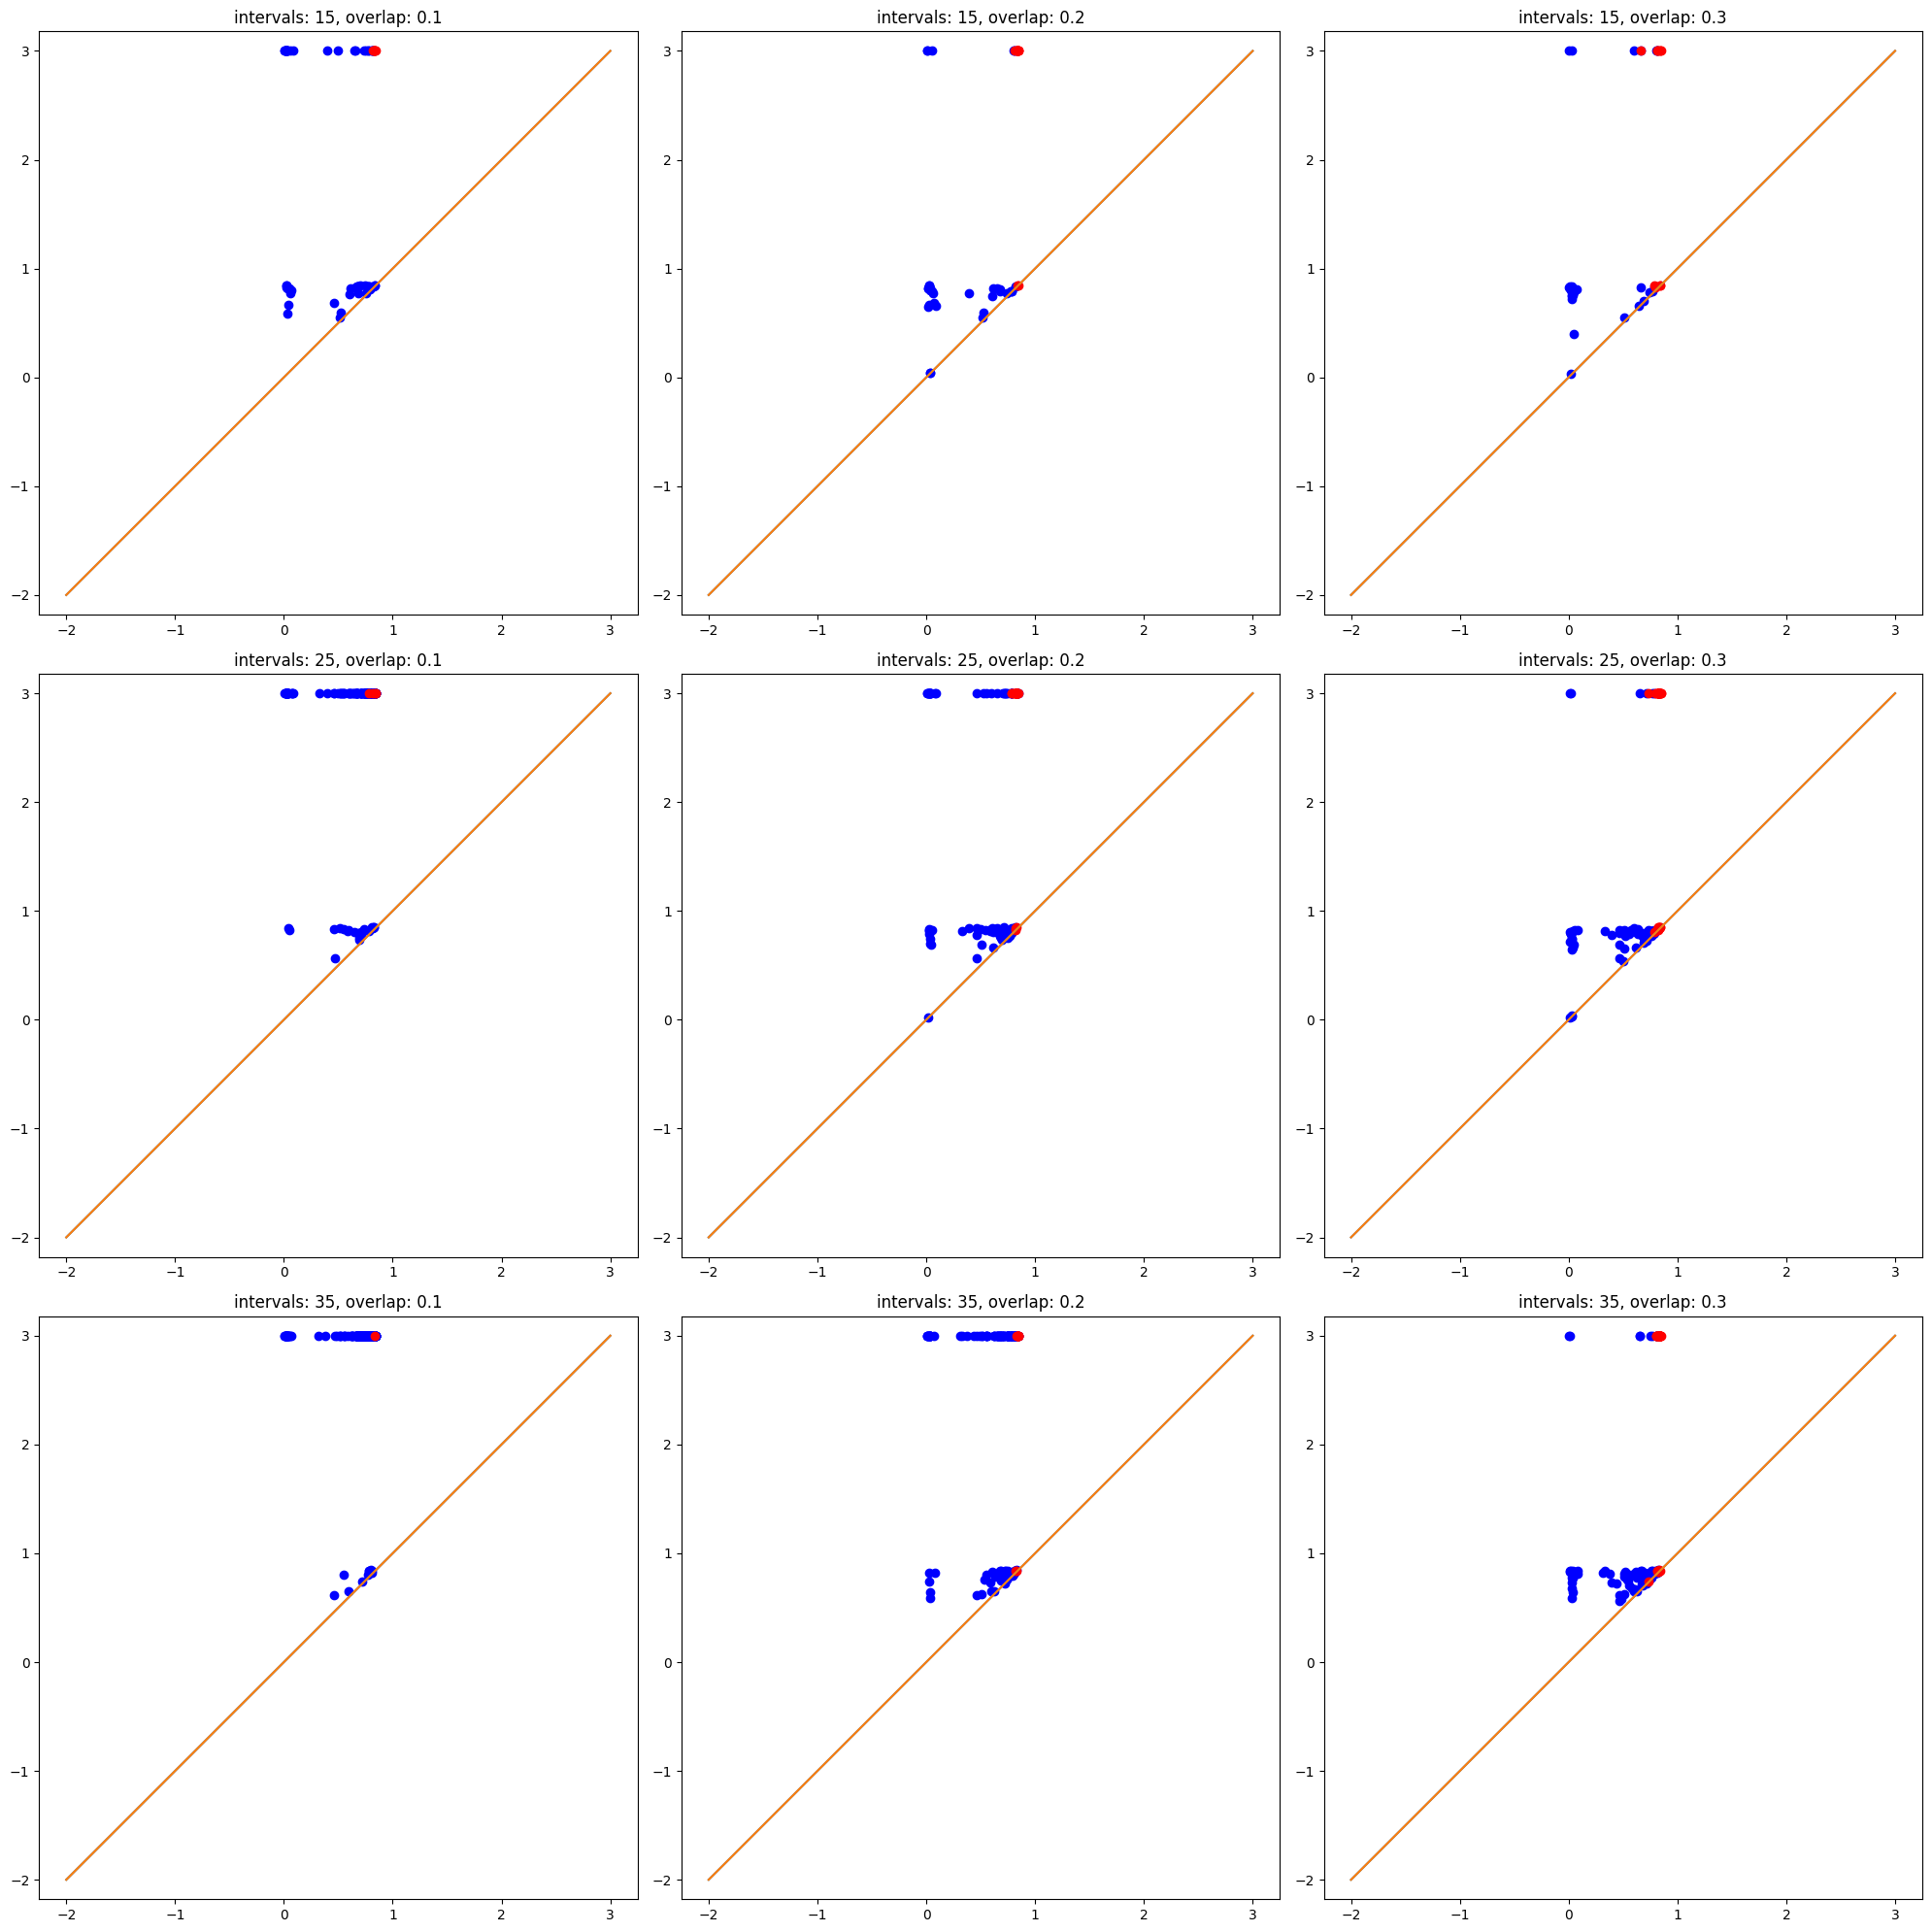

In [188]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(20,20)

interval_bar = tqdm([15, 25, 35])

for ax_i, n_intervals in enumerate(interval_bar):
    for ax_j, overlap_frac in enumerate([0.1,0.2,0.3]):
        interval_bar.set_description(f"overlap_frac: {overlap_frac}")

        cover = CubicalCover(n_intervals=n_intervals, overlap_frac=overlap_frac, algorithm="standard")
        clust = DBSCAN(eps=5)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.max([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        d.plot.plot_all_diagrams(dgms, ax=ax[ax_i, ax_j], pt_style={"c":"g"})
        ax[ax_i, ax_j].set_title(f"intervals: {n_intervals}, overlap: {overlap_frac}")
plt.tight_layout()

  0%|          | 0/3 [00:00<?, ?it/s]

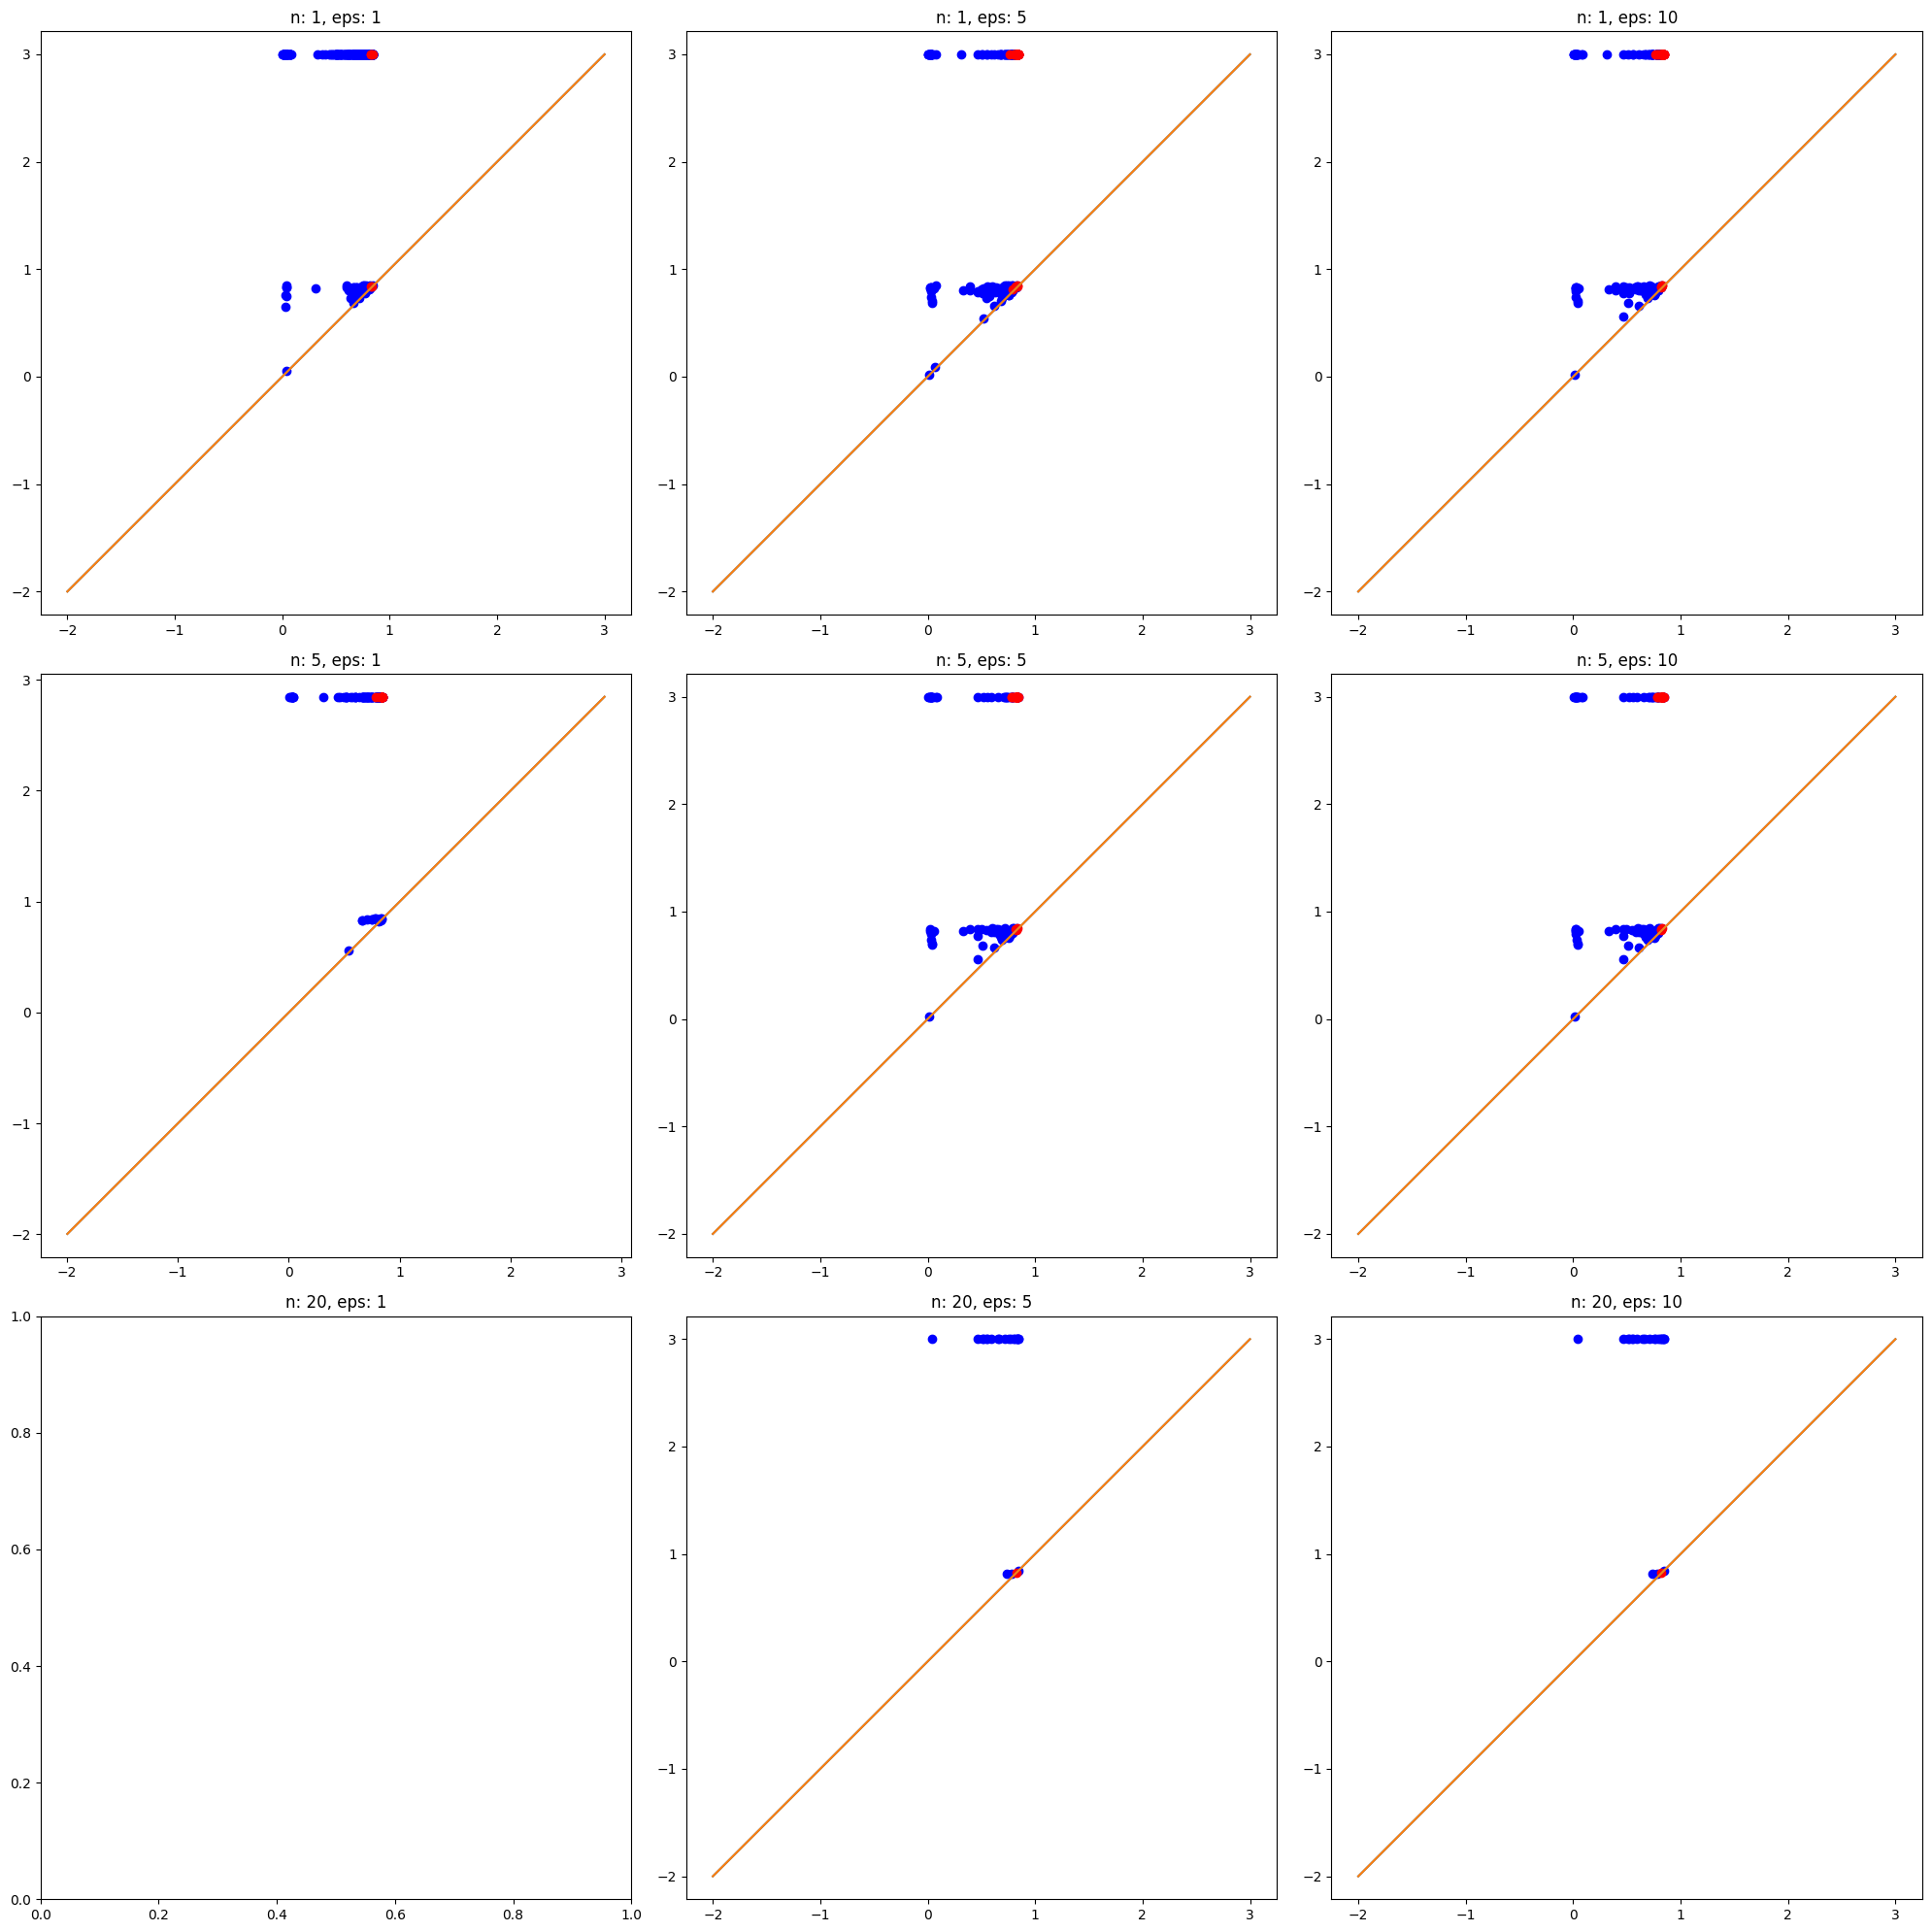

In [189]:
fig, ax = plt.subplots(3,3)
fig.set_size_inches(20,20)

samples_bar = tqdm([1, 5, 20])

for ax_i, dbscan_min_samples in enumerate(samples_bar):
    for ax_j, dbscan_eps in enumerate([1,5,10]):
        samples_bar.set_description(f"dbscan_eps: {dbscan_eps}")

        cover = CubicalCover(n_intervals=25, overlap_frac=0.2, algorithm="standard")
        clust = DBSCAN(eps=dbscan_eps, min_samples = dbscan_min_samples)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.max([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        d.plot.plot_all_diagrams(dgms, ax=ax[ax_i, ax_j])
        # try:
        #     d.plot.plot_diagram(dgms[0], ax=ax[ax_i, ax_j], pt_style={"c":"b"})
        # except:
        #     print(f"Didn't work for n: {dbscan_min_samples}, eps: {dbscan_eps}")
        #     continue
        # d.plot.plot_diagram(dgms[1], ax=ax[ax_i, ax_j], pt_style={"c":"r"})
        # d.plot.plot_diagram(dgms[2], ax=ax[ax_i, ax_j], pt_style={"c":"g"})
        ax[ax_i, ax_j].set_title(f"n: {dbscan_min_samples}, eps: {dbscan_eps}")
plt.tight_layout()

  0%|          | 0/5 [00:00<?, ?it/s]

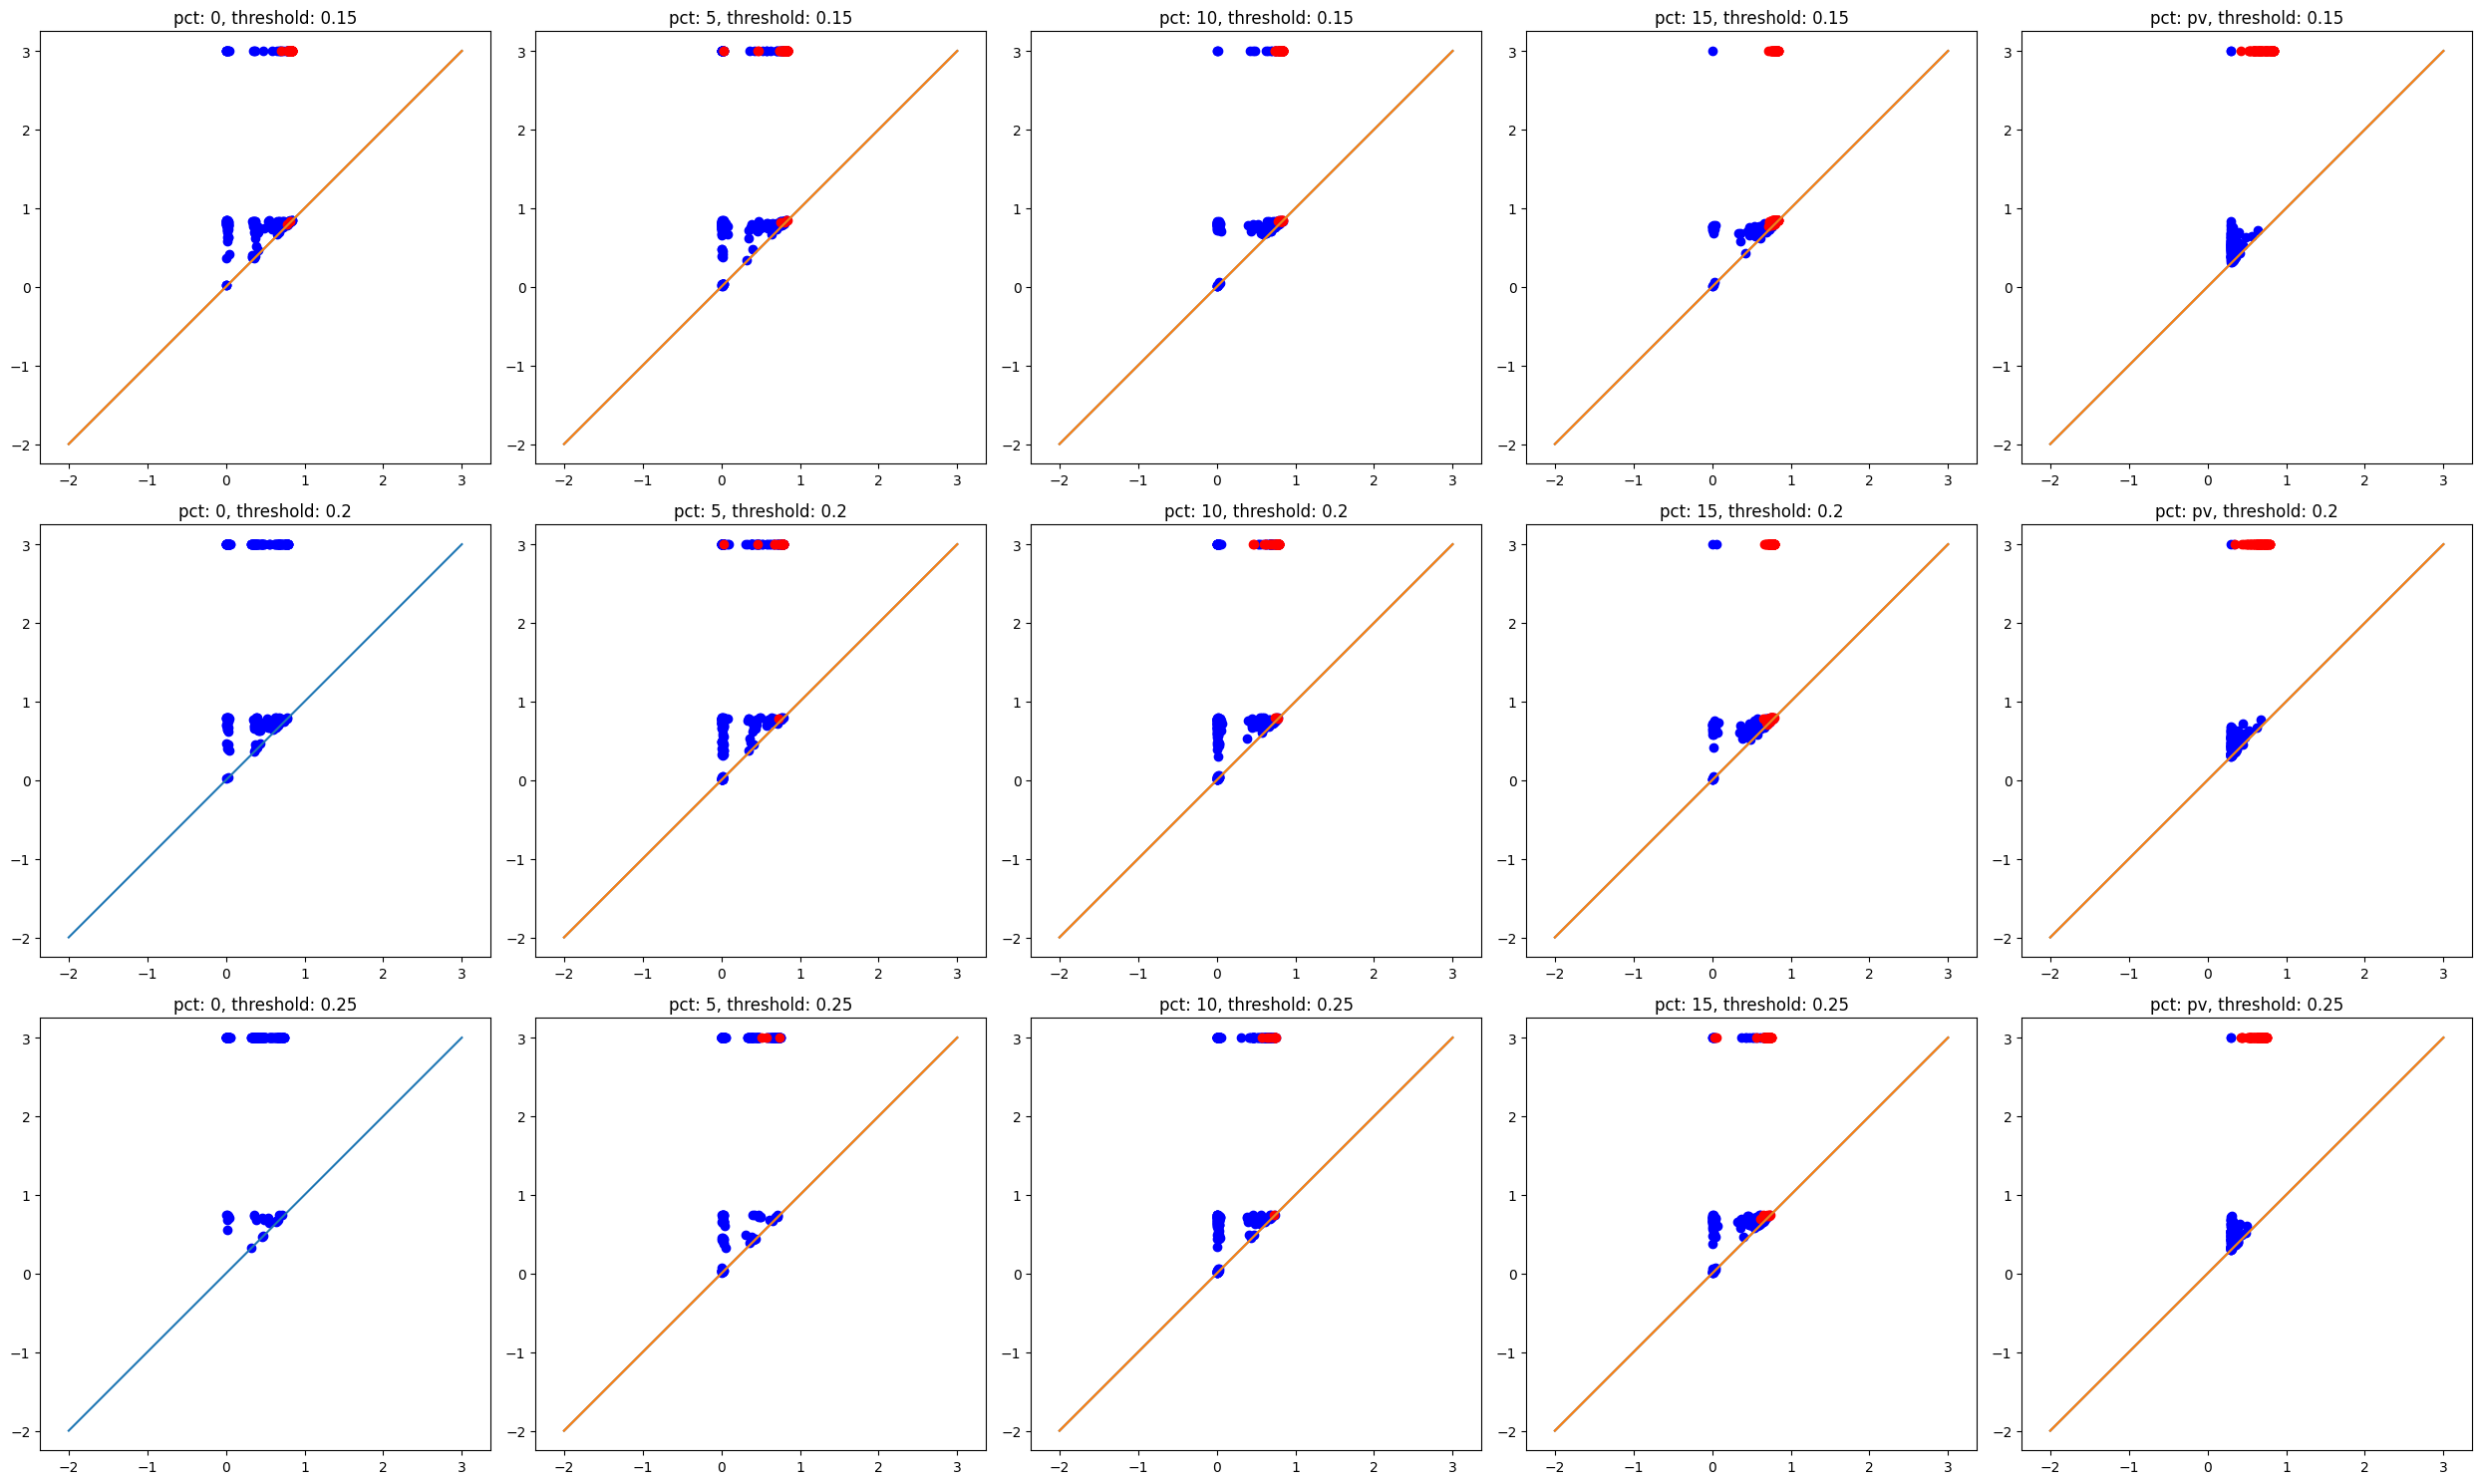

In [192]:
fig, ax = plt.subplots(3,5)
fig.set_size_inches(25,15)

pct_bar = tqdm(["0", "5", "10", "15", "pv"])


for ax_j, pct in enumerate(pct_bar):
    for ax_i, threshold in enumerate([0.15,0.2,0.25]):
        if pct != "pv":
            im_gray = 1-np.array(Image.open(f"../figures/GND{pct}pct_rotated.jpg").convert("L")).astype(int)/255
        else:
            im_gray = 1-np.array(Image.open(f"../figures/tot10_0_2d.png").convert("L")).astype(int)/255

        X = np.vstack(np.where(im_gray>threshold)).T
        y = [im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])]

        pct_bar.set_description(f"threshold: {threshold}")

        cover = CubicalCover(n_intervals=25, overlap_frac=0.2, algorithm="standard")
        clust = DBSCAN(eps=5)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.max([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        d.plot.plot_all_diagrams(dgms, ax=ax[ax_i, ax_j])
        ax[ax_i, ax_j].set_title(f"pct: {pct}, threshold: {threshold}")
plt.tight_layout()

  0%|          | 0/4 [00:00<?, ?it/s]

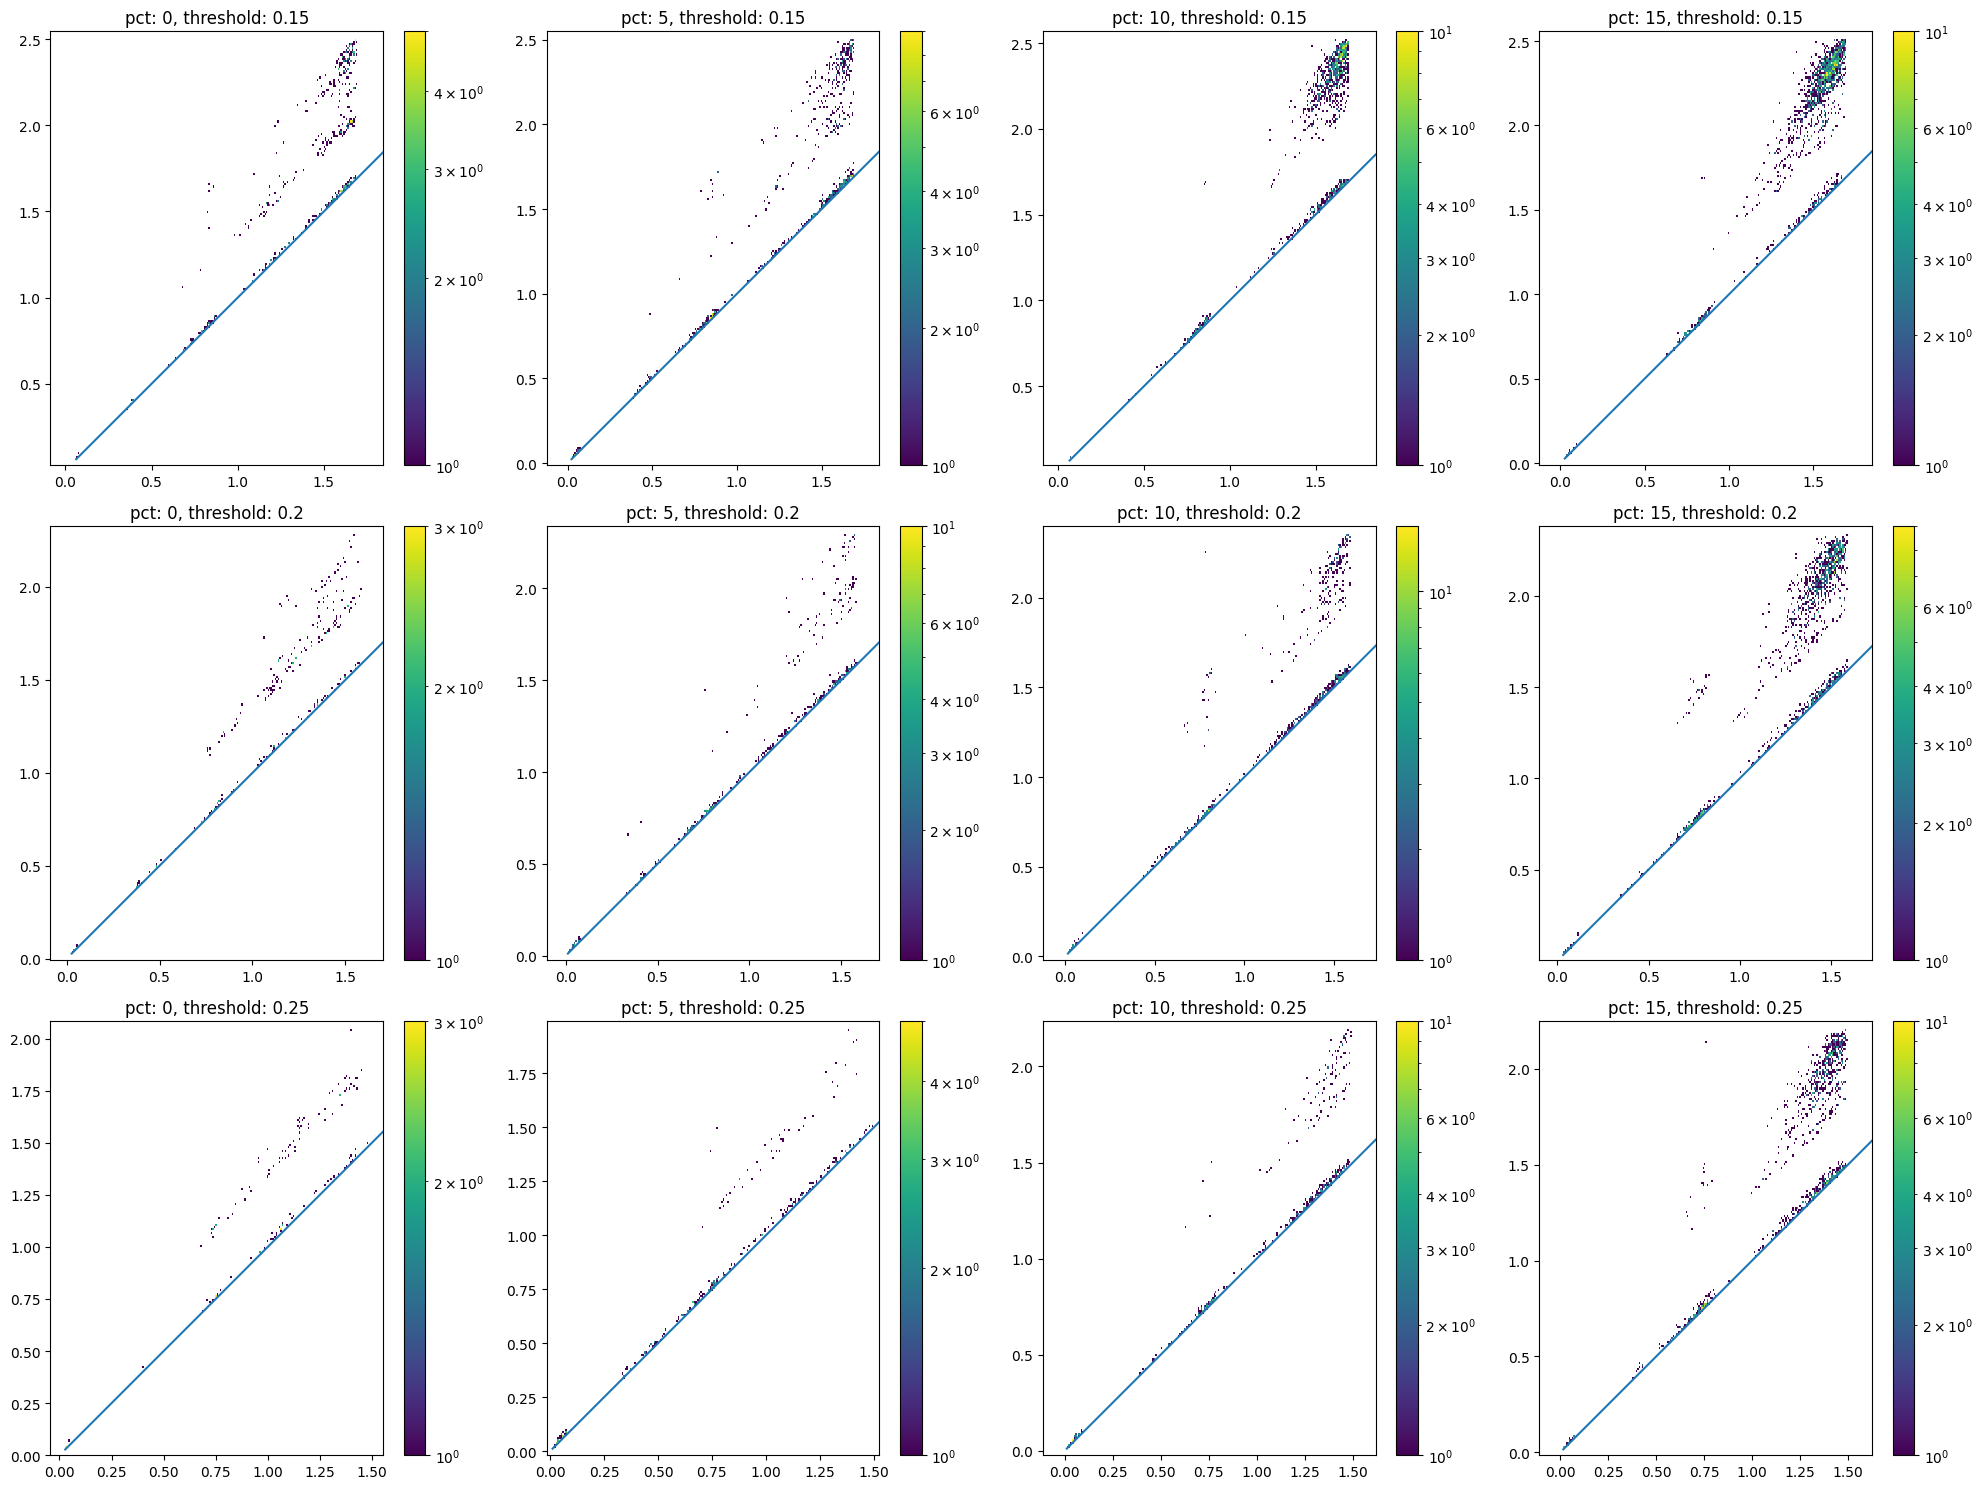

In [60]:
fig, ax = plt.subplots(3,4)
fig.set_size_inches(20,15)

pct_bar = tqdm(["0", "5", "10", "15"])


for ax_j, pct in enumerate(pct_bar):
    for ax_i, threshold in enumerate([0.15,0.2,0.25]):
        im_gray = 1-np.array(Image.open(f"../figures/GND{pct}pct_rotated.jpg").convert("L")).astype(int)/255

        X = np.vstack(np.where(im_gray>threshold)).T
        y = [im_gray[X[i,0], X[i,1]] for i in range(X.shape[0])]

        pct_bar.set_description(f"threshold: {threshold}")

        cover = CubicalCover(n_intervals=25, overlap_frac=0.2, algorithm="standard")
        clust = DBSCAN(eps=5)
        graph = MapperAlgorithm(cover, clust).fit_transform(X, X)

        simplices = []
        for c in networkx.enumerate_all_cliques(graph):
            simplices.append((c, np.sum([1-y[i] for i in c])))

        f = d.Filtration()
        for vertices, time in simplices:
            f.append(d.Simplex(vertices, time))
        f.sort()
        p = d.cohomology_persistence(f, prime=47)
        dgms = d.init_diagrams(p, f)
        # d.plot.plot_diagram_density(dgms[0], ax=ax[ax_i, ax_j])
        d.plot.plot_diagram_density(dgms[1], ax=ax[ax_i, ax_j])
        # d.plot.plot_diagram_density(dgms[2], ax=ax[ax_i, ax_j])
        ax[ax_i, ax_j].set_title(f"pct: {pct}, threshold: {threshold}")
plt.tight_layout()

In [30]:
node_info = {"node_id": [], "neighbors": [], "KAM": []}
for node in graph.nodes:
    
    node_info["node_id"].append(str(node))
    node_info["neighbors"].append([i for i in graph.neighbors(node)])
    node_info["KAM"].append(np.mean(np.array([y[i] for i in graph.nodes[node]["ids"]])))
    
node_df = pd.DataFrame(node_info).set_index("node_id").sort_values(by="KAM", ascending=False)

edge_info = {"edge_id": [], "KAM": []}
for edge in graph.edges:
    edge = [str(i) for i in edge]
    edge_info["edge_id"].append(",".join(edge))
    edge_info["KAM"].append(np.sum([node_df.loc[edge[0]]["KAM"], node_df.loc[edge[1]]["KAM"]]))

edge_df = pd.DataFrame(edge_info).set_index("edge_id").sort_values(by="KAM", ascending=False)

Cohomology persistence of 3753 cells

In [110]:
cluster_means = []
for i_cluster, cluster in enumerate(cover.apply(X)):
    m = np.mean([X[i] for i in cluster], axis=0)
    cluster_means.append(m)
cluster_means = np.array(cluster_means)

In [112]:
cluster_means.shape

(562, 2)

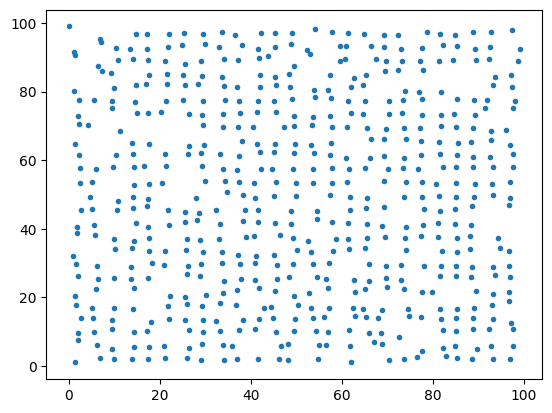

In [113]:
plt.scatter(cluster_means[:, 0], cluster_means[:, 1], marker=".")